In [1]:
import config
from cnn_builder import *
from dataset_functions import *
import gc
from hypercube_set import HypercubeSet
from hypercube_loader import *
import papers.aspn
import glob
import keras
import numpy as np
import os
import paths
import pickle
from rendering import *
import sys

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

%load_ext autoreload
%autoreload 2

inf = 2e32

## Dataset

In [2]:
sampling_strategy = 'not minority'

Reading media/Mateus_2022/red\raw_112_rf.hdr ...


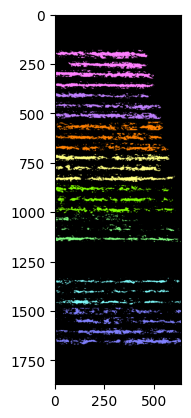

Reading media/Mateus_2022/red\raw_1984_rf.hdr ...


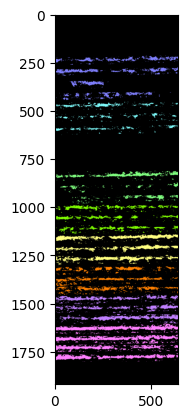

Reading media/Mateus_2022/red\raw_3904_rf.hdr ...


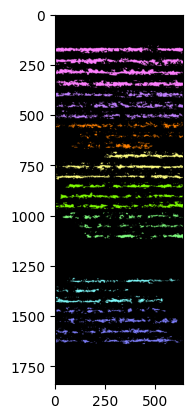

Reading media/Mateus_2022/red\raw_5744_rf.hdr ...


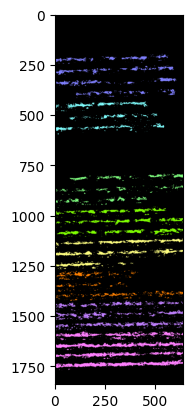

Reading media/Mateus_2022/red\raw_7584_rf.hdr ...


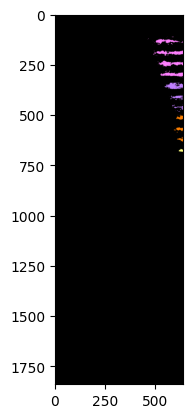

{(0, 0, 0): 0, (255, 128, 255): 1, (128, 128, 255): 2, (192, 128, 255): 3, (128, 255, 255): 4, (255, 128, 0): 5, (255, 255, 128): 6, (128, 255, 128): 7, (128, 255, 0): 8}
Class 0.0 has 5345833 pixels.
Class 1.0 has 144315 pixels.
Class 2.0 has 67157 pixels.
Class 3.0 has 75078 pixels.
Class 4.0 has 35656 pixels.
Class 5.0 has 53620 pixels.
Class 6.0 has 71547 pixels.
Class 7.0 has 36114 pixels.
Class 8.0 has 58680 pixels.
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)
on 0: (549185, 223)                                                                                                     
|████████████████████████████████████████| 2/2 [100%] in 1:07.6 (0.02/s)                                                0%] in 36s (~0s, 0.0/s)  █▆▄ 0/2 [0%] in 1:01 (~0s, 0.0/s)  ▆▄▂ 0/2 [0%] in 1:04 (~0s, 0.0/s) 


(FactorAnalysis(n_components=30, random_state=42), StandardScaler())

In [18]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=True, n_max_cubes=inf))
hc_set.print_metadata()

#### Dataset creation
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=test_split, patch_size=config.patch_size, patch_overlapping=config.patch_overlapping)

#### Preprocessing
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

In [5]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

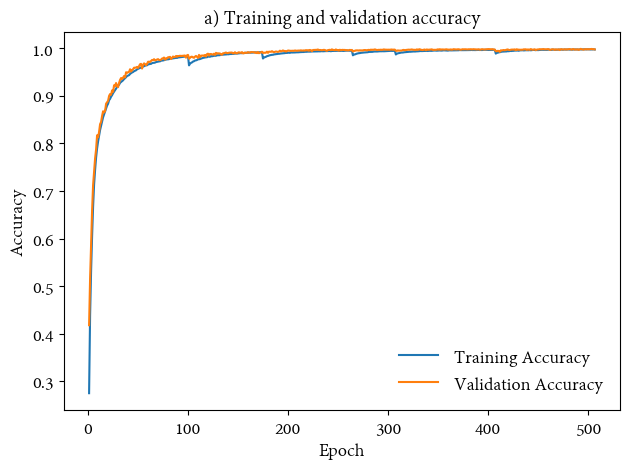

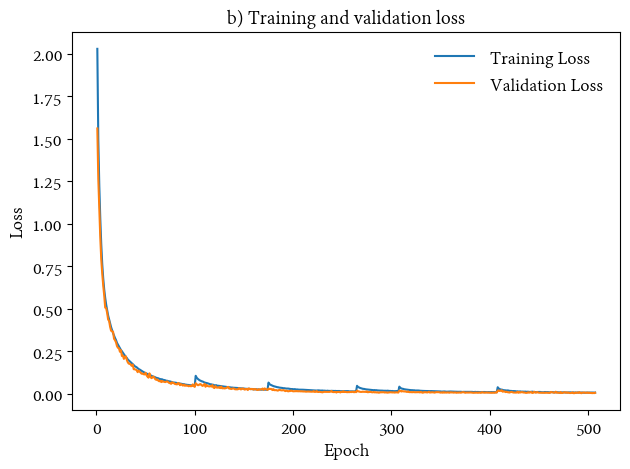

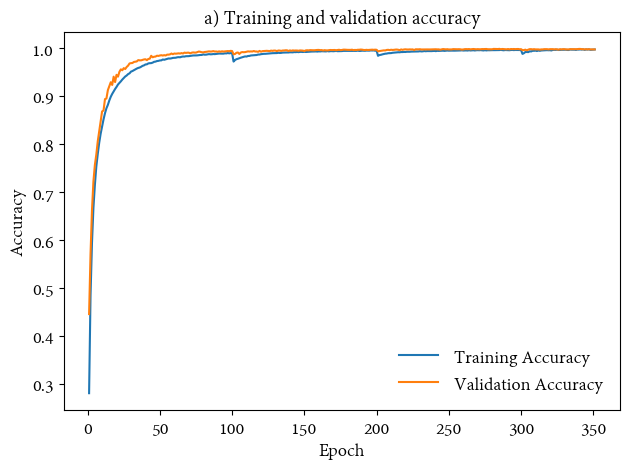

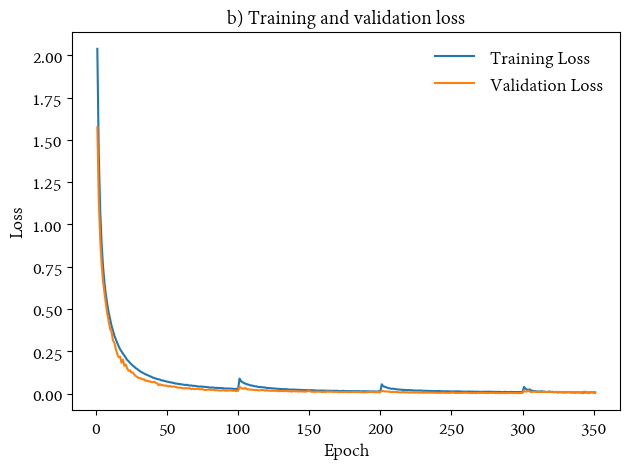

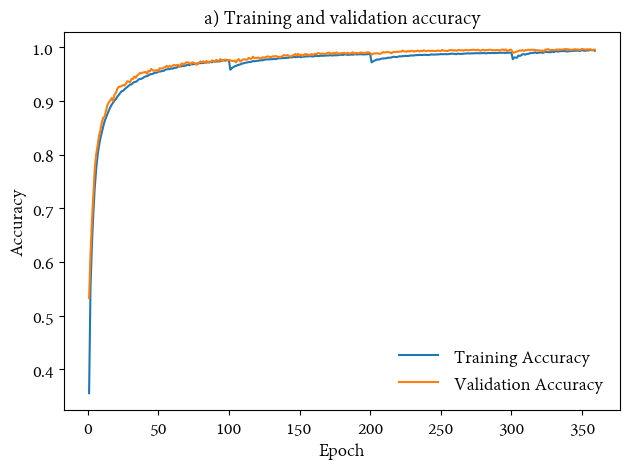

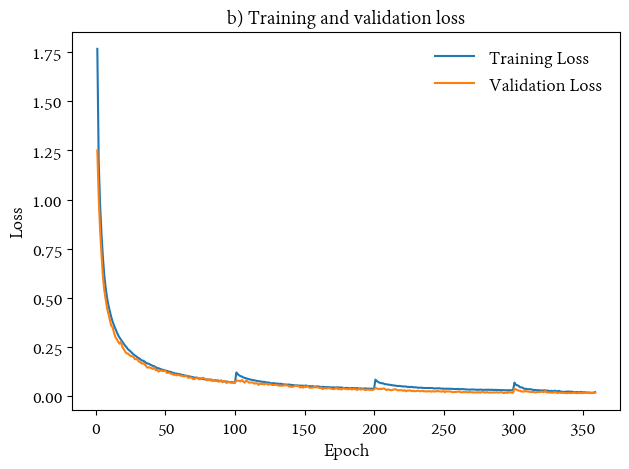

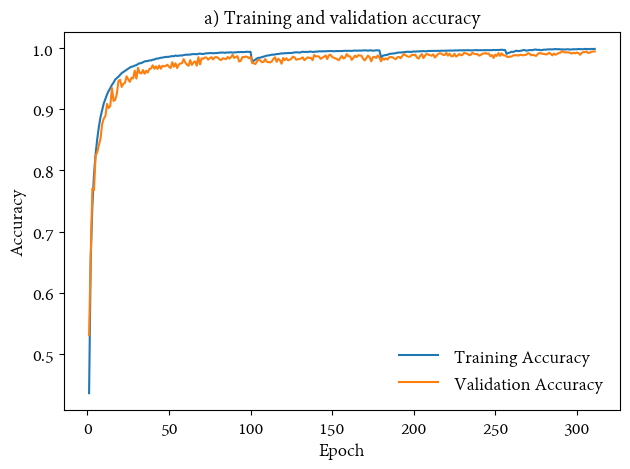

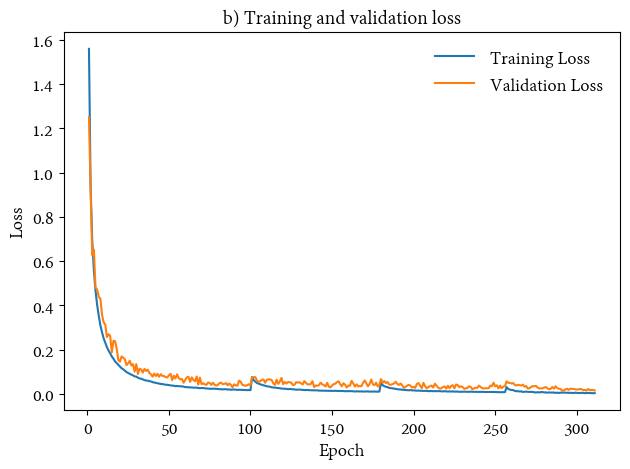

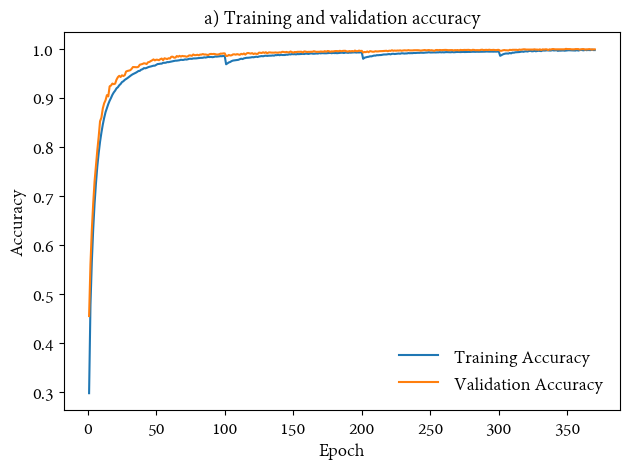

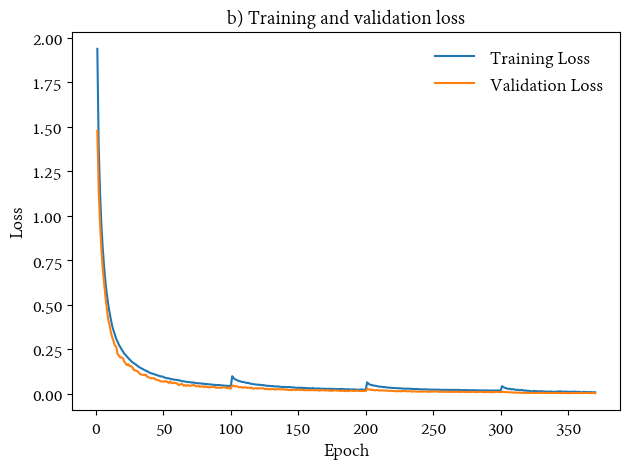

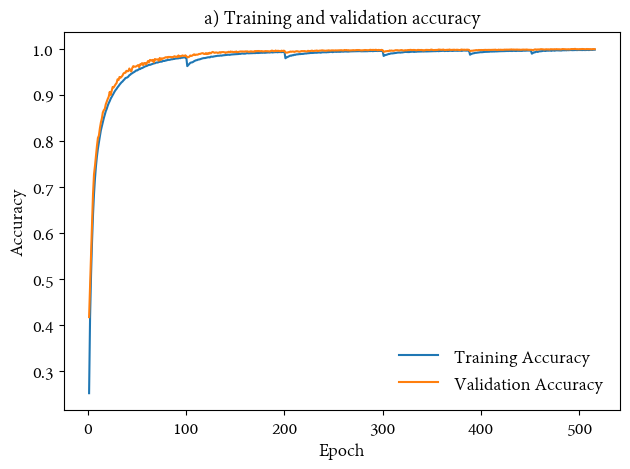

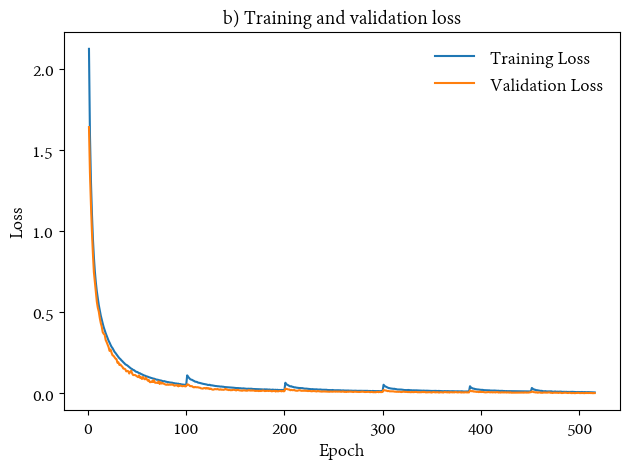

In [20]:
# Look for a file with the network name under the history folder
history_file = os.path.join(paths.result_folder + 'history/', network_name + "*.p")
history_files = glob.glob(history_file)

for history_file in history_files:
    # Load history with pickle
    history = pickle.load(open(history_file, "rb"))
    render_model_history(history, model_name=network_name)

In [21]:
# Read network weights
network_weights_file = os.path.join(paths.result_folder + 'network/', network_name + "*.h5")
network_weights_files = glob.glob(network_weights_file)
if len(network_weights_files) > 0:
    network_weights_file = network_weights_files[-1]
    print("Loading weights file " + network_weights_file)
    model = keras.models.load_model(network_weights_file,
                                    custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                    'SecondOrderPooling': papers.aspn.SecondOrderPooling})

    model.summary()

Loading weights file results/red/network\allopezr_2d_23x22_16_window_size_test_0.h5
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 23, 23, 30)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape_14 (Reshape)           (None, 529, 30)      0           ['input_8[0][0]']                
                                                                                                  
 lambda_7 (Lambda)              (None, 529, 30)      0           ['reshape_14[0][0]']             
                                                                                                  
 spatial

In [ ]:
num_classes = hc_set.get_num_classes()
if paths.target_area == 2:
    num_classes -= 3

In [ ]:
### Split test
X_test, y_test = hc_set.split_test(patch_size=config.patch_size)
y_test = reduce_labels_center(y_test)
X_test, y_test = remove_labels(X_test, y_test, [num_classes, num_classes + 1, num_classes + 2])
(X_test, y_test), _, _ = balance_classes(X_test, y_test, reduce=True, clustering=False,
                                         strategy=sampling_strategy)

In [ ]:
test_prediction_prob = model.predict(X_test)
test_prediction = np.argmax(test_prediction_prob, axis=1)
metrics.append_evaluation(y_test, test_prediction, test_prediction_prob)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

## Window Size Tests

### OA

In [9]:
# Read network metrices with network_type root name (e.g. allopezr_2d)
network_metrics_file = os.path.join(paths.result_folder + 'metrics/', network_type + "*_window_size_test.p")
network_metrics_files = glob.glob(network_metrics_file)

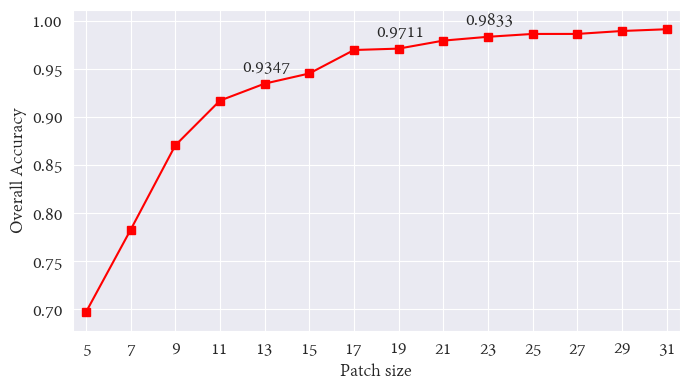

In [20]:
oa_window_size = []

for network_metrics_file in network_metrics_files:
    # Load history with pickle
    network_metrics = pickle.load(open(network_metrics_file, "rb"))
    # Extract patch size from file name
    file_name_strings = network_metrics_file.split("_")
    for string in file_name_strings:
        if 'x' in string:
            patch_size = int(string.split("x")[0])
            break

    oa_window_size.append((patch_size, network_metrics.get_oa()))

# Sort by patch size
oa_window_size.sort(key=lambda tup: tup[0])
render_window_size_metric(oa_window_size, annotate_indices=[4, 7, 9])

### Training time + capacity

In [11]:
# Read history files
# Read network metrices with network_type root name (e.g. allopezr_2d)
network_history_file = os.path.join(paths.result_folder + 'history/', network_type + "*_window_size_test_0.p")
network_history_files = glob.glob(network_history_file)

network_file = os.path.join(paths.result_folder + 'network/', network_type + "*_window_size_test_0.h5")
network_files = glob.glob(network_file)

In [12]:
training_time = []
capacity = []

for (history_file, network_file) in zip(network_history_files, network_files):
    # Load history with pickle
    network_history = pickle.load(open(history_file, "rb"))
    # Extract patch size from file name
    file_name_strings = network_file.split("_")
    for string in file_name_strings:
        if 'x' in string:
            patch_size = int(string.split("x")[0])
            break

    model = keras.models.load_model(network_file,
                                custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                'SecondOrderPooling': papers.aspn.SecondOrderPooling})
    model.num_params = model.count_params()

    training_time.append((patch_size, network_history.get_training_time()))
    capacity.append((patch_size, model.num_params))

    del model
    gc.collect()

# Sort by patch size
training_time.sort(key=lambda tup: tup[0])
capacity.sort(key=lambda tup: tup[0])

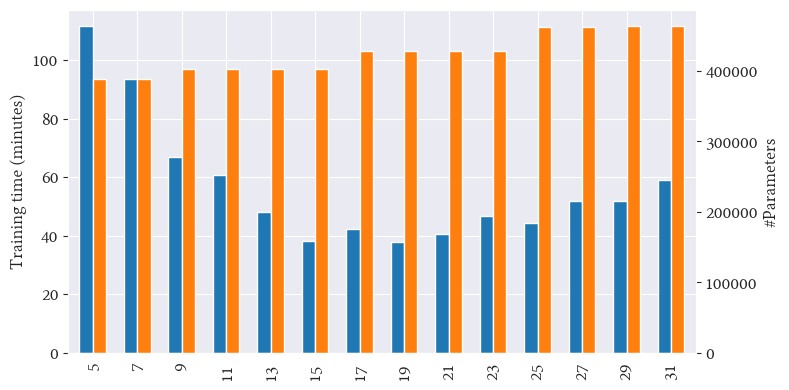

In [22]:
render_time_capacity(training_time, capacity)

## Ablation study

In [ ]:
ablation_suffix = ["no_input_convs", "naive_exception", "advanced_exception", "no_attention"]

# Search files with ablation suffixes in metrics folder
ablation_metrics_files = []
for suffix in ablation_suffix:
    ablation_metrics_file = os.path.join(paths.result_folder + 'metrics/', network_type + "*_" + suffix + ".p")
    ablation_metrics_files.append(glob.glob(ablation_metrics_file))

for (ablation_label, metric_file) in zip(ablation_suffix, ablation_metrics_files):
    # Load history with pickle
    print('------------- ' + ablation_label + ' -------------')
    network_metrics = pickle.load(open(metric_file[0], "rb"))
    print(network_metrics.print_metrics())

# History time and num parameters

In [9]:
from keras.layers import Lambda
import papers.spectral_net

network_types = [ 'allopezr_2d', 'lt_cnn', 'nezami', 'jigsaw_hsi', 'spectral_net', 'hybrid_sn', 'aspn']
network_label = ['Ours', 'Lt-CNN', 'Nezami et al.', 'Jigsaw HSI', 'SpectralNet', 'HybridSN', 'ASPN']
num_params_typeset = [0, 0, 0, 0, 7826889, 0, 8229]
training_time = []
num_params = []

for network_type in network_types:
    print(network_type)
    read_json_config(paths.config_file, network_type=network_type)
    network_name = get_name(network_type)

    # read history pickle file
    history_files = glob.glob(os.path.join(paths.result_folder + 'history/', network_name + "_0.p"))
    for history_file in history_files:
        history = pickle.load(open(history_file, "rb"))
        training_time.append(history.get_training_time())

    # read network pickle file
    network_files = glob.glob(os.path.join(paths.result_folder + 'network/', network_name + "*.h5"))
    for network_file in network_files:
        try:
            model = keras.models.load_model(network_file,
                                        custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                        'SecondOrderPooling': papers.aspn.SecondOrderPooling})
            model.num_params = model.count_params()
            num_params.append(model.num_params)

            del model
            gc.collect()
            break
        except Exception as e:
            print(e)
            num_params.append(num_params_typeset[network_types.index(network_type)])
            break

allopezr_2d
results/uav/history/allopezr_2d_23x22_16_0.p
lt_cnn
results/uav/history/lt_cnn_23x22_64_0.p
nezami
results/uav/history/nezami_25x24_20_0.p
jigsaw_hsi
results/uav/history/jigsaw_hsi_25x24_0_0.p
spectral_net
results/uav/history/spectral_net_24x23_64_0.p
Error loading model
Exception encountered when calling layer "wavelet" (type Lambda).

unknown opcode

Call arguments received by layer "wavelet" (type Lambda):
  • inputs=tf.Tensor(shape=(None, 24, 24, 40), dtype=float32)
  • mask=None
  • training=False
hybrid_sn
results/uav/history/hybrid_sn_25x24_8_0.p
aspn
results/uav/history/aspn_9x8_32_0.p
Error loading model
Unknown initializer: Symmetry. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [10]:
print(training_time)
print(num_params)

[3307.9000425338745, 9686.327056646347, 1515.7593524456024, 13661.94010233879, 2593.4007003307343, 12865.303440332413, 593.9884874820709]
[562995, 3157977, 45571, 28272179, 7826889, 5306625, 8229]


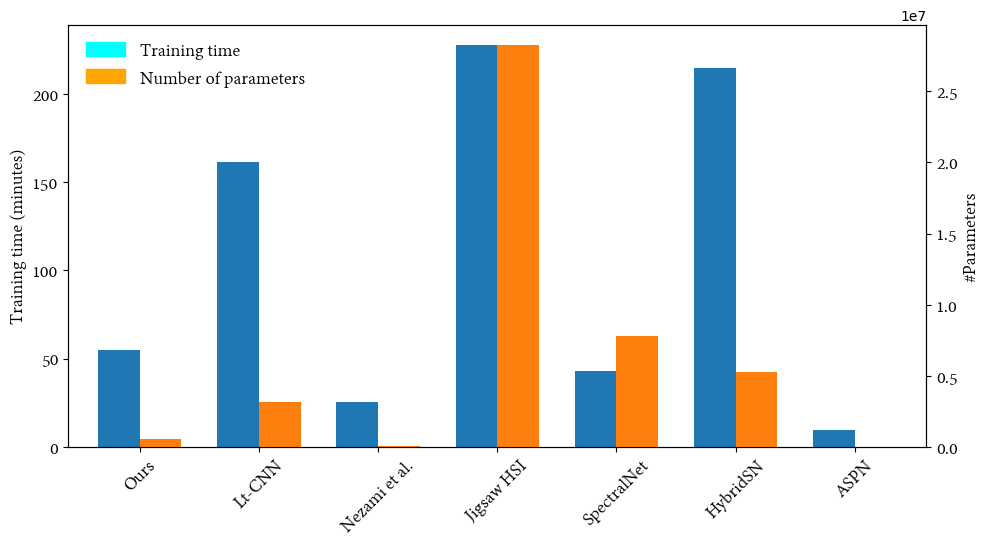

In [17]:
render_network_training(network_label, training_time, num_params, bar_width=0.7)

# Spatial labelling

In [3]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

In [4]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=2e32))
hc_set.print_metadata()
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size,
                            patch_overlapping=config.patch_overlapping)
num_classes = hc_set.get_num_classes()
hc_set.swap_classes(0, num_classes - 1)
reduction, scaler = hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Reading media/Mateus_2021/white\raw_10208_rf.hdr ...
Reading media/Mateus_2021/white\raw_12400_rf.hdr ...
Reading media/Mateus_2021/white\raw_14400_rf.hdr ...
Reading media/Mateus_2021/white\raw_16592_rf.hdr ...
Reading media/Mateus_2021/white\raw_18592_rf.hdr ...
Reading media/Mateus_2021/white\raw_20912_rf.hdr ...
Reading media/Mateus_2021/white\raw_22912_rf.hdr ...
Reading media/Mateus_2021/white\raw_4128_rf.hdr ...
Reading media/Mateus_2021/white\raw_6128_rf.hdr ...
Reading media/Mateus_2021/white\raw_8208_rf.hdr ...
Class 0.0 has 10953299 pixels.
Class 1.0 has 412297 pixels.
Class 2.0 has 136221 pixels.
Class 3.0 has 111267 pixels.
Class 4.0 has 433109 pixels.
Class 5.0 has 223278 pixels.
Class 6.0 has 91418 pixels.
Class 7.0 has 133336 pixels.
Class 8.0 has 166665 pixels.
Class 9.0 has 139110 pixels.
Min: 0.010506520979106426, Max: 0.23533053696155548, Size: (2000, 6400, 223)
on 0: (1595867, 223)                                                                                     

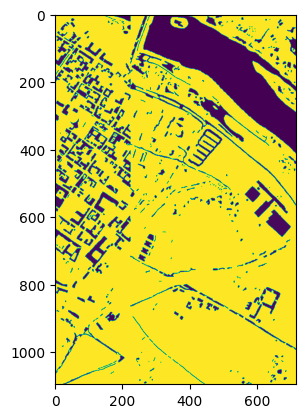

Class 0: 65971
Class 1: 7598
Class 2: 3090
Class 3: 2685
Class 4: 6584
Class 5: 9248
Class 6: 7287
Class 7: 42826
Class 8: 2863
Class 9: 635488
Min: 0.0, Max: 8000.0, Size: (1096, 715, 102)
on 0: (548548, 102)                                                                                                     
|████████████████████████████████████████| 2/2 [100%] in 7:50.8 (0.00/s)                                                ] in 7s (~0s, 0.0/s)  ▂▄▆ 0/2 [0%] in 11s (~0s, 0.0/s)  █▆▄ 0/2 [0%] in 15s (~0s, 0.0/s)  ▇▇▅ 0/2 [0%] in 20s (~0s, 0.0/s)  ▆▄▂ 0/2 [0%] in 29s (~0s, 0.0/s)  ▂▂▄ 0/2 [0%] in 33s (~0s, 0.0/s)  ▆█▆ 0/2 [0%] in 52s (~0s, 0.0/s)  ▂▂▄ 0/2 [0%] in 56s (~0s, 0.0/s)  ▆█▆ 0/2 [0%] in 1:07 (~0s, 0.0/s)  ▅▃▁ 0/2 [0%] in 1:13 (~0s, 0.0/s)  ▇▇▅ 0/2 [0%] in 1:18 (~0s, 0.0/s)  ▃▅▇ 0/2 [0%] in 1:34 (~0s, 0.0/s)  ▇▅▃ 0/2 [0%] in 1:42 (~0s, 0.0/s)  ▄▆█ 0/2 [0%] in 1:48 (~0s, 0.0/s)  ▆█▆ 0/2 [0%] in 2:12 (~0s, 0.0/s)  ▂▂▄ 0/2 [0%] in 2:14 (~0s, 0.0/s)  ▄▂▂ 0/2 [0%] in 2:21 (~0s, 0.

In [3]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type) + '_pavia_centre'

config.batch_size = 512

#### Hypercube reading
hc_set = HypercubeSet(hc_array=[load_pavia_centre_umat(plot_hc=False, plot_mask=True)])
hc_set.print_metadata()
ground_label = hc_set.get_most_frequent_label()

#### Dataset creation
hc_set.obtain_ground_labels(ground_label=ground_label)
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size,
                            patch_overlapping=config.patch_overlapping)

#### Preprocessing
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

#### Build network
num_classes = hc_set.get_num_classes() - 1
img_shape = (config.patch_size, config.patch_size, config.num_target_features)

In [19]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=2e32))
hc_set.print_metadata()
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size,
                            patch_overlapping=config.patch_overlapping)
num_classes = hc_set.get_num_classes()
hc_set.swap_classes(0, num_classes - 1)
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Reading media/Mateus_2021/white\raw_10208_rf.hdr ...
Reading media/Mateus_2021/white\raw_12400_rf.hdr ...
Reading media/Mateus_2021/white\raw_14400_rf.hdr ...
Reading media/Mateus_2021/white\raw_16592_rf.hdr ...
Reading media/Mateus_2021/white\raw_18592_rf.hdr ...
Reading media/Mateus_2021/white\raw_20912_rf.hdr ...
Reading media/Mateus_2021/white\raw_22912_rf.hdr ...
Reading media/Mateus_2021/white\raw_4128_rf.hdr ...
Reading media/Mateus_2021/white\raw_6128_rf.hdr ...
Reading media/Mateus_2021/white\raw_8208_rf.hdr ...
Class 0.0 has 10953299 pixels.
Class 1.0 has 412297 pixels.
Class 2.0 has 136221 pixels.
Class 3.0 has 111267 pixels.
Class 4.0 has 433109 pixels.
Class 5.0 has 223278 pixels.
Class 6.0 has 91418 pixels.
Class 7.0 has 133336 pixels.
Class 8.0 has 166665 pixels.
Class 9.0 has 139110 pixels.
Min: 0.010506520979106426, Max: 0.23533053696155548, Size: (2000, 6400, 223)
on 0: (1595867, 223)                                                                                     

(FactorAnalysis(n_components=30, random_state=42), StandardScaler())

In [5]:
# Load network
network_file = os.path.join(paths.result_folder + 'network/', network_name + "_0.h5")
model = keras.models.load_model(network_file,
                            custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                            'SecondOrderPooling': papers.aspn.SecondOrderPooling})

Processing hypercube 0
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.5s (208860.08/s)                                   
X_train_swath shape: (89180, 23, 23, 30)
2787/2787 [==============================] - 24s 7ms/step
Processed 100000 pixels
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.6s (162278.84/s)                                   
X_train_swath shape: (96780, 23, 23, 30)
3025/3025 [==============================] - 22s 7ms/step
Processed 200000 pixels
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.6s (177807.90/s)                                   
X_train_swath shape: (96780, 23, 23, 30)
3025/3025 [==============================] - 22s 7ms/step
Processed 300000 pixels
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.7s (149340.86/s)                                   
X_train_

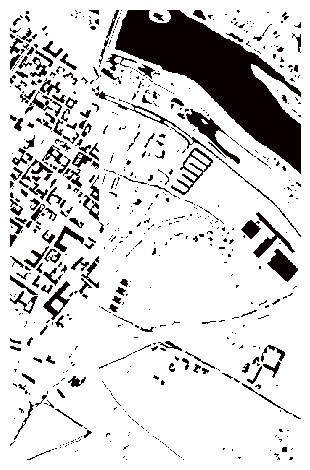

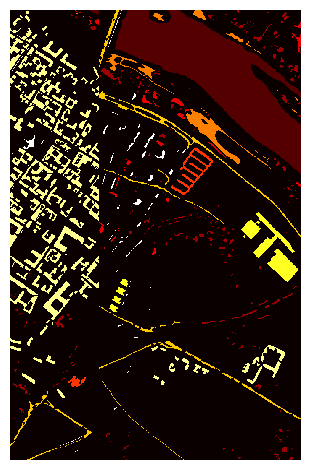

In [6]:
batch_size = 100000
num_hypercubes = hc_set.get_num_hypercubes()

for i in range(0, num_hypercubes):
    print("Processing hypercube " + str(i))

    predicted_swath = None
    y_swath = None
    num_processed_pixels = 0

    while True:
        X_train_swath, y_train_swath = hc_set.split_swath(patch_size=config.patch_size, patch_id=i, limit=batch_size, offset=num_processed_pixels)
        if X_train_swath is not None:
            print("X_train_swath shape: " + str(X_train_swath.shape))
        if X_train_swath is None:
            break
        if X_train_swath.shape[0] == 0:
            break

        y_train_swath = reduce_labels_center(y_train_swath)
        predicted_labels = model.predict(X_train_swath)
        predicted_labels = np.argmax(predicted_labels, axis=1)

        if predicted_swath is None:
            predicted_swath = predicted_labels
            y_swath = y_train_swath
        else:
            predicted_swath = np.append(predicted_swath, predicted_labels)
            y_swath = np.append(y_swath, y_train_swath)

        num_processed_pixels += batch_size
        del X_train_swath, y_train_swath, predicted_labels
        gc.collect()

        print("Processed " + str(num_processed_pixels) + " pixels")

    label_diff, shaped_prediction, _ = hc_set.compose_swath_evaluation(y_swath, predicted_swath, patch_size=config.patch_size)
    rendering.render_label_diff(label_diff=label_diff, filename='swaths/' + paths.target_area + '_' + str(i) + '.png')
    rendering.render_label_diff(label_diff=shaped_prediction, filename='swaths/' + paths.target_area + '_predicted_' + str(i) + '.png')

    del predicted_swath, y_swath
    gc.collect()

## Class separability

In [4]:
# Load network
network_file = os.path.join(paths.result_folder + 'network/', network_name + "_0.h5")
model = keras.models.load_model(network_file,
                            custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                            'SecondOrderPooling': papers.aspn.SecondOrderPooling})

In [5]:
hc_array_red, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/red/')
hc_array_white, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/white/', baseline_class_idx=max_class_idx)

hc_array = hc_array_red + hc_array_white
hc_set = HypercubeSet(hc_array)
hc_set.identify_ground_samples()
hc_set.split_hypercubes(test_percentage=test_split)
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
Hypercube shape: (1872, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_1984_rf.hdr ...
Hypercube shape: (1920, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_3904_rf.hdr ...
Hypercube shape: (1840, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_5744_rf.hdr ...
Hypercube shape: (1840, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (

(FactorAnalysis(n_components=40, random_state=42), StandardScaler())

In [6]:
X_train, y_train = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=True, start_percentage=0.5, end_percentage=0.505)
#X_train, y_train = randomness.stratified_sampling(X_train, y_train, use_float=True, num_reduced_classes=3)

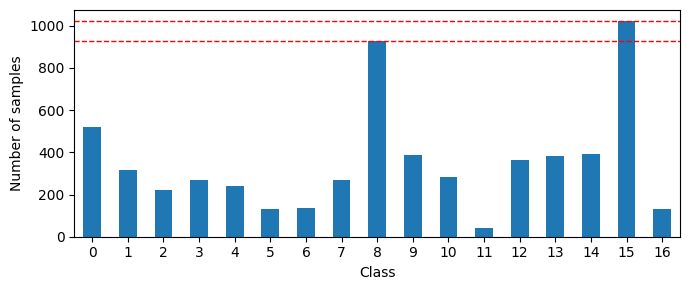

In [7]:
render_mask_histogram(y_train)

In [8]:
predict_model = keras.Model(model.input, model.layers[-2].output)
predict_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 23, 40)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape (Reshape)              (None, 529, 40)      0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 529, 40)      0           ['reshape[0][0]']                
                                                                                                  
 spatial_attention (SpatialAtte  (None, 529, 40)     1058        ['lambda[0][0]']             

In [71]:
predicted_train = predict_model.predict(X_train)
predicted_y_train = np.argmax(model.predict(X_train), axis=1)

# Retrieve only those that were correctly predicted
predicted_train = predicted_train[y_train == predicted_y_train]
y_train = y_train[y_train == predicted_y_train]

376/376 [==============================] - 3s 8ms/step


In [9]:
predicted_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))

In [10]:
embedding = embed_manifold(predicted_train, True, num_components=2)

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



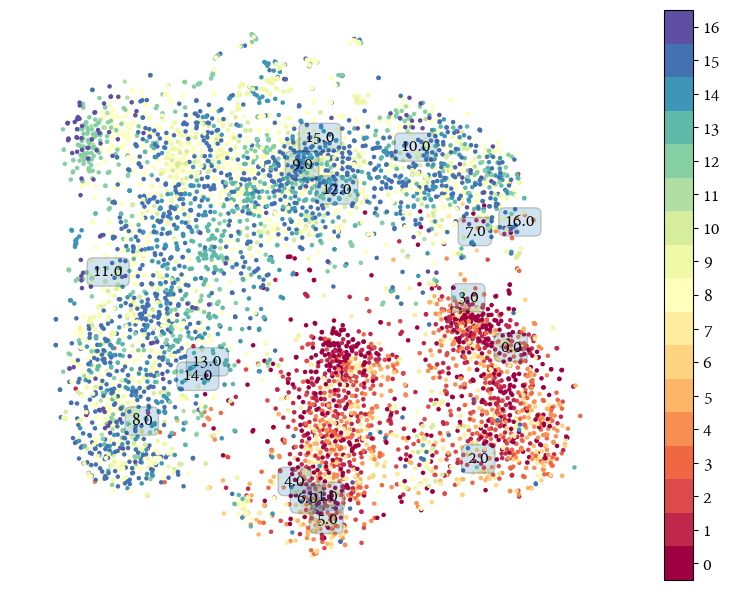

In [11]:
render_manifold_separability(embedding, y_train, include_annotations=True)

### 3D

In [20]:
embedding = embed_manifold(predicted_train, True, num_components=3)
render_3d_manifold_separability(embedding, y_train)

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



KeyboardInterrupt: 